# Fraud Classification - Apply saved model
<BR><BR>The purpose of this notebook is to apply a trained Machine Learning model to predict if a new transaction is potentially fraud.

### Steps in this notebook
-  Connect to SAP HANA
-  Load the trained model from SAP HANA
-  Create a SAP HANA DataFrame which points to the data that is to be used for a prediction
-  Apply the model that has been loaded on the data and predict fraud probability

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/319d36de4fd64ac3afbf91b1fb3ce8de/cloud/en-US
-  SAP HANA Automated Predictive Library (APL):
   https://help.sap.com/viewer/product/apl/2018/en-US

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(key = 'NA_POC_HANA_CLOUD', encrypt = 'true',sslValidateCertificate = 'false')

### Generate the data to be scored with appropriate features
Get data for a day in August, and calculate features

In [2]:
df_time = conn.sql("select CT_ID, CT_FLAG_FRAUD, CT_AMOUNT, CT_FEE, hour(CT_DATE) as HOUR_TXN, weekday(CT_DATE) as WEEKDAY_TXN from SOURCEDATA.VT_CARD_TRANSACTIONS where CT_DAYDATE = '2020-08-01'")

In [3]:
df_time.count()

54500

In [4]:
df_time.head(5).collect()

,CT_ID,CT_FLAG_FRAUD,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN
0,131501387,0,21.2,0.22,0,5
1,131503472,0,21.2,0.22,4,5
2,131503750,0,21.2,0.22,5,5
3,131504020,0,21.2,0.22,6,5
4,131505122,0,21.2,0.22,7,5


In [5]:
df_avg_spend_2020 = conn.sql("select CT_ID, \
                             case when c.AVG_SPEND_2020 = 0 then 0 else round(t.CT_AMOUNT / c.AVG_SPEND_2020, 2) end as RATIO_AMOUNT_AVG_SPEND_2020 \
                             from SOURCEDATA.VT_CARD_TRANSACTIONS t, \
                             ( select CT_CUST_ID, avg(CT_AMOUNT) as AVG_SPEND_2020 from SOURCEDATA.VT_CARD_TRANSACTIONS \
                                where CT_DATE < '2020-07-01' \
                                group by CT_CUST_ID ) c \
                             where t.CT_DAYDATE = '2020-08-01' and t.CT_CUST_ID = c.CT_CUST_ID")

In [6]:
df_customer_ratios = conn.sql("select CT_ID, \
                     case when c.CUST_AVG_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_AVG_SPEND, 2) end as RATIO_AMOUNT_AVG_SPEND, \
                     case when c.CUST_LIFE_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_LIFE_SPEND, 2) end as RATIO_AMOUNT_LIFE_SPEND, \
                     case when c.CUST_INCOME = 0 then 0 else round(t.CT_AMOUNT / c.CUST_INCOME, 2) end as RATIO_AMOUNT_INCOME \
                     from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.CUSTOMER c \
                     where t.CT_DAYDATE = '2020-08-01' and t.CT_CUST_ID = c.CUST_ID")

In [7]:
df_card_features = conn.sql("select CT_ID, CARD_INTERNATIONAL, \
                    case when c.CARD_LIMIT = 0 then 0 else round(t.CT_AMOUNT / c.CARD_LIMIT, 2) end as RATIO_AMOUNT_LIMIT \
                    from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.CARD c \
                    where t.CT_DAYDATE = '2020-08-01' and t.CT_CUST_ID = c.CARD_ID")

In [8]:
df_merchant_features = conn.sql("select CT_ID, MER_SEGMENT, MER_FLAG_VIRTUAL_STORE \
                                from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm \
                                where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID")

In [9]:
df_new_merchant_store = conn.sql("select CT_ID, 1 as FLAG_NEW_MERCHANT_STORE \
                        from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm \
                        where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID and tm.MER_FLAG_VIRTUAL_STORE not in \
                        (   select distinct MER_FLAG_VIRTUAL_STORE as CUST_MERCHANTS \
                            from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                            where c.CT_DATE < '2020-07-01' \
                            and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID ) \
                        union all \
                        select CT_ID, 0 as FLAG_NEW_MERCHANT_STORE \
                        from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm \
                        where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID and tm.MER_FLAG_VIRTUAL_STORE in \
                        (   select distinct MER_FLAG_VIRTUAL_STORE as CUST_MERCHANTS \
                            from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                            where c.CT_DATE < '2020-07-01' \
                            and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID)")

In [10]:
df_new_merchant_segment = conn.sql("select CT_ID, 1 as FLAG_NEW_MERCHANT_SEGMENT \
                                    from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm \
                                    where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID and tm.MER_SEGMENT not in \
                                    (    select distinct MER_SEGMENT as CUST_MERCHANTS \
                                         from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                                         where c.CT_DATE < '2020-07-01' \
                                         and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID ) \
                                    union all \
                                    select CT_ID, 0 as FLAG_NEW_MERCHANT_SEGMENT \
                                    from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm \
                                    where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID and tm.MER_SEGMENT in \
                                    (    select distinct MER_SEGMENT as CUST_MERCHANTS \
                                         from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
                                         where c.CT_DATE < '2020-07-01' \
                                         and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID)")

In [11]:
df_weather = conn.sql("select CT_ID, \
avg_air_temperature_daily, \
avg_air_temp_7_days, \
avg_relative_humidity_daily, \
avg_relative_humidity_7_days, \
avg_wind_speed_daily, \
avg_wind_speed_7_days \
from SOURCEDATA.VT_CARD_TRANSACTIONS t, SOURCEDATA.MERCHANT_CA tm, \
(	select weather_date, county, \
	avg_precipitation_daily, \
	avg(avg_precipitation_daily) over (partition by county order by weather_date rows 6 preceding ) avg_precipitation_7_days, \
	avg_air_temperature_daily, \
	avg(avg_air_temperature_daily) over (partition by county order by weather_date rows 6 preceding ) avg_air_temp_7_days, \
	avg_relative_humidity_daily, \
	avg(avg_relative_humidity_daily) over (partition by county order by weather_date rows 6 preceding ) avg_relative_humidity_7_days, \
	avg_wind_speed_daily, \
	avg(avg_wind_speed_daily) over (partition by county order by weather_date rows 6 preceding ) avg_wind_speed_7_days from ( \
               select datetime_date weather_date, \
               county, \
               avg(precipitation) avg_precipitation_daily, \
               avg(air_temperature) avg_air_temperature_daily, \
               avg(relative_humidity)  avg_relative_humidity_daily, \
               avg(wind_speed) avg_wind_speed_daily \
               from SOURCEDATA.VT_CA_WEATHER_SENSOR_DAILY a \
               join SOURCEDATA.VT_WEATHER_STATIONS b on a.station_id = b.\"Station Number\" \
               group by datetime_date, county \
               order by 1,2 ) ) w \
where t.CT_DAYDATE = '2020-08-01' and t.CT_MER_ID = tm.MER_ID and \
tm.COUNTY = w.COUNTY and \
t.CT_DAYDATE = w.WEATHER_DATE")

In [12]:
df_time_avgspend = df_time.alias('T').join(df_avg_spend_2020.alias('A'), 'T.CT_ID = A.CT_ID', 
                                           select = [('T.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 'RATIO_AMOUNT_AVG_SPEND_2020', 'CT_FLAG_FRAUD'])

In [13]:
df_ta_customer = df_time_avgspend.alias('TA').join(df_customer_ratios.alias('C'), 'TA.CT_ID = C.CT_ID',
                                                   select = [('TA.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 'RATIO_AMOUNT_INCOME', 'CT_FLAG_FRAUD'])

In [14]:
df_tac_card = df_ta_customer.alias('TAC').join(df_card_features.alias('CA'), 'TAC.CT_ID = CA.CT_ID',
                                              select = [('TAC.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'CT_FLAG_FRAUD'])

In [15]:
df_tacc_merchant = df_tac_card.alias('TACC').join(df_merchant_features.alias('M'), 'TACC.CT_ID = M.CT_ID',
                                              select = [('TACC.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'CT_FLAG_FRAUD'])

In [16]:
df_taccm_ns = df_tacc_merchant.alias('TACCM').join(df_new_merchant_store.alias('NS'), 'TACCM.CT_ID = NS.CT_ID',
                                              select = [('TACCM.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE',
                                                        'CT_FLAG_FRAUD'])

In [17]:
df_taccmn_s = df_taccm_ns.alias('TACCMN').join(df_new_merchant_segment.alias('S'), 'TACCMN.CT_ID = S.CT_ID',
                                              select = [('TACCMN.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE', 'FLAG_NEW_MERCHANT_SEGMENT',
                                                        'CT_FLAG_FRAUD'])

In [18]:
df_final = df_taccmn_s.alias('TACCMNS').join(df_weather.alias('W'), 'TACCMNS.CT_ID = W.CT_ID',
                                              select = [('TACCMNS.CT_ID', 'CT_ID'),'CT_AMOUNT', 'CT_FEE', 'HOUR_TXN', 'WEEKDAY_TXN', 
                                                        'RATIO_AMOUNT_AVG_SPEND_2020', 'RATIO_AMOUNT_AVG_SPEND', 'RATIO_AMOUNT_LIFE_SPEND', 
                                                        'RATIO_AMOUNT_INCOME', 
                                                        'CARD_INTERNATIONAL', 'RATIO_AMOUNT_LIMIT',
                                                        'MER_SEGMENT', 'MER_FLAG_VIRTUAL_STORE',
                                                        'FLAG_NEW_MERCHANT_STORE', 'FLAG_NEW_MERCHANT_SEGMENT',
                                                        'AVG_AIR_TEMPERATURE_DAILY', 'AVG_AIR_TEMP_7_DAYS', 
                                                        'AVG_RELATIVE_HUMIDITY_DAILY', 'AVG_RELATIVE_HUMIDITY_7_DAYS',
                                                        'AVG_WIND_SPEED_DAILY', 'AVG_WIND_SPEED_7_DAYS',
                                                        'CT_FLAG_FRAUD'])

In [19]:
df_final.count()

47574

### Load model
Load the trained model from SAP HANA.

In [20]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'BIUSER' # HANA schema from where models are to be loaded
model_storage = ModelStorage(connection_context = conn, schema = MODEL_SCHEMA)
gbapl_model = model_storage.load_model(name = 'Fraud Classification Model', version = 1)

### Predict probability of fraud for new transactions

Peak at the transactions that are to be predicted.

In [21]:
df_final.head(3).collect()

,CT_ID,CT_AMOUNT,CT_FEE,HOUR_TXN,WEEKDAY_TXN,RATIO_AMOUNT_AVG_SPEND_2020,RATIO_AMOUNT_AVG_SPEND,RATIO_AMOUNT_LIFE_SPEND,RATIO_AMOUNT_INCOME,CARD_INTERNATIONAL,...,MER_FLAG_VIRTUAL_STORE,FLAG_NEW_MERCHANT_STORE,FLAG_NEW_MERCHANT_SEGMENT,AVG_AIR_TEMPERATURE_DAILY,AVG_AIR_TEMP_7_DAYS,AVG_RELATIVE_HUMIDITY_DAILY,AVG_RELATIVE_HUMIDITY_7_DAYS,AVG_WIND_SPEED_DAILY,AVG_WIND_SPEED_7_DAYS,CT_FLAG_FRAUD
0,131503877,45.15,0.46,5,5,0.75,0.0,0.0,0.0,0,...,0,0,1,89.62,87.01,35.75,39.75,4.92,4.57,0
1,131523244,48.42,1.95,13,5,0.15,0.0,0.0,0.0,0,...,0,0,1,89.62,87.01,35.75,39.75,4.92,4.57,0
2,131529958,12.85,0.65,15,5,0.21,0.0,0.0,0.0,0,...,0,0,1,71.93,71.21,59.2,60.78,7.51,9.78,0


Apply the trained model on the new data to predict fraud.

In [22]:
gbapl_model.set_params(extra_applyout_settings =
                        {'APL/ApplyExtraMode': 'Advanced Apply Settings',
                         'APL/ApplyDecision': 'true',
                         'APL/ApplyProbability': 'true',
                         'APL/ApplyPredictedValue': 'false'
                        })
df_remote_predict = gbapl_model.predict(df_final)

In [23]:
df_predict = df_remote_predict.head(10).collect()
df_predict

,CT_ID,TRUE_LABEL,PREDICTED,gb_proba_CT_FLAG_FRAUD
0,131523687,0,1,0.265542
1,131530815,0,0,0.113055
2,131533849,0,0,0.113055
3,131508260,0,1,0.281860
4,131520751,0,0,0.109080
5,131542778,0,0,0.108613
6,131511137,0,0,0.113055
7,131511454,0,0,0.113055
8,131535628,0,0,0.108613
9,131502173,0,0,0.135303


In [24]:
df_predict = df_predict.drop('TRUE_LABEL', axis = 1) # Remove actual that is null
df_predict.columns = [hdr.replace('gb_', '') for hdr in df_predict.columns] # shorten column names
df_predict.style.format({'proba_CT_FLAG_FRAUD':'{0:,.3f}'}).hide_index() 

CT_ID,PREDICTED,proba_CT_FLAG_FRAUD
131523687,1,0.266
131530815,0,0.113
131533849,0,0.113
131508260,1,0.282
131520751,0,0.109
131542778,0,0.109
131511137,0,0.113
131511454,0,0.113
131535628,0,0.109
131502173,0,0.135


In [25]:
df_remote_predict.save(where=('BIUSER', 'FRAUD_PREDICTED_PROBABILITY'), 
                       table_type = 'COLUMN', 
                       force = True)

In [26]:
gbapl_model.set_params(extra_applyout_settings={'APL/ApplyExtraMode': 'Individual Contributions'})
df_remote_predict_contrib = gbapl_model.predict(df_final)
df_predict_contrib = df_remote_predict_contrib.head(10).collect()
df_predict_contrib = df_predict_contrib.drop('TRUE_LABEL', axis = 1) # Remove Actual that is null
df_predict_contrib.columns = [hdr.replace("gb_", "") for hdr in df_predict_contrib.columns] # Shorten column names
df_predict_contrib

,CT_ID,PREDICTED,score_CT_FLAG_FRAUD,contrib_CT_AMOUNT,contrib_CT_FEE,contrib_HOUR_TXN,contrib_WEEKDAY_TXN,contrib_RATIO_AMOUNT_AVG_SPEND_2020,contrib_RATIO_AMOUNT_AVG_SPEND,contrib_RATIO_AMOUNT_LIFE_SPEND,...,contrib_RATIO_AMOUNT_LIMIT,contrib_MER_FLAG_VIRTUAL_STORE,contrib_FLAG_NEW_MERCHANT_STORE,contrib_FLAG_NEW_MERCHANT_SEGMENT,contrib_AVG_AIR_TEMPERATURE_DAILY,contrib_AVG_RELATIVE_HUMIDITY_DAILY,contrib_AVG_RELATIVE_HUMIDITY_7_DAYS,contrib_AVG_WIND_SPEED_DAILY,contrib_AVG_WIND_SPEED_7_DAYS,contrib_constant_bias
0,131523687,1,-1.017362,-0.000768,0.001289,-0.239512,0.247353,1.344125,0.011173,-0.046611,...,-0.019105,0.050996,-0.002868,-0.032594,-0.000062,0.000009,0.0,-0.00190,0.000027,-2.224359
1,131501014,0,-2.247487,0.000569,0.000414,0.631493,0.410534,-0.264858,-0.030619,-0.006481,...,-0.003484,-0.571660,-0.003007,-0.034950,-0.000062,0.000017,0.0,-0.00190,0.000005,-2.224359
2,131549589,0,-2.542667,0.000132,-0.000530,0.537668,0.341548,-0.258790,-0.031773,-0.006410,...,-0.003169,-0.701571,-0.003122,-0.035316,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359
3,131532173,0,-2.673737,0.000132,-0.000530,-0.192902,0.477037,-0.296815,-0.036999,-0.006361,...,-0.003665,-0.162468,-0.003019,-0.036960,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359
4,131545777,0,-2.627484,0.000197,-0.000426,-0.370770,0.439658,-0.280887,-0.036084,-0.006264,...,-0.003533,0.074562,-0.002992,-0.036535,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359
5,131515473,0,-2.673737,0.000132,-0.000530,-0.192902,0.477037,-0.296815,-0.036999,-0.006361,...,-0.003665,-0.162468,-0.003019,-0.036960,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359
6,131505622,1,-0.186325,-0.001806,0.001289,-0.221188,0.229530,1.266830,0.645158,0.151284,...,-0.010746,0.052195,-0.002786,-0.028418,-0.000062,0.000575,0.0,-0.00190,0.000239,-2.224359
7,131522590,1,-0.128711,-0.001491,0.001443,-0.121628,0.230251,1.351988,0.626783,0.125263,...,0.041322,-0.105690,-0.002794,-0.028348,-0.000062,0.000575,0.0,-0.00329,0.000239,-2.224359
8,131509342,0,-2.627484,0.000197,-0.000426,-0.370770,0.439658,-0.280887,-0.036084,-0.006264,...,-0.003533,0.074562,-0.002992,-0.036535,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359
9,131550407,1,-0.899126,0.000197,0.001289,1.127386,0.284330,-0.194795,-0.027101,-0.006245,...,-0.003181,0.302270,-0.002956,-0.031746,-0.000062,0.000017,0.0,-0.00190,0.000006,-2.224359


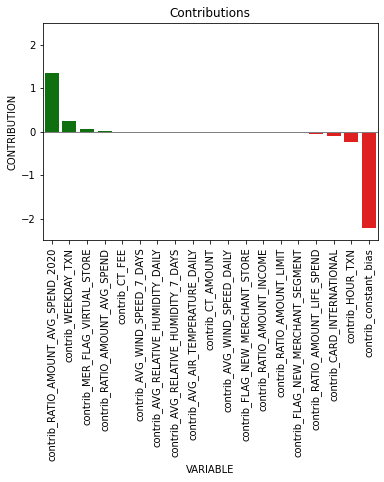

In [27]:
df_contributions_single = df_predict_contrib[df_predict_contrib['CT_ID'] == 131523687]
df_contributions_single = df_contributions_single.melt(id_vars = ['CT_ID', 'PREDICTED', 'score_CT_FLAG_FRAUD'])
df_contributions_single.columns = ['CT_ID', 'PREDICTED', 'SCORE', 'VARIABLE', 'CONTRIBUTION']
df_contributions_single = df_contributions_single.sort_values(by = ['CONTRIBUTION'], ascending = [False])
df_contributions_single.style.format({'CONTRIBUTION':'{0:,.3f}'}).hide_index() 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 
plt.figure()
bar_color = np.where(df_contributions_single['CONTRIBUTION'] > 0 ,'green', 'red')
bplot = sns.barplot(data = df_contributions_single, x = 'VARIABLE', y = 'CONTRIBUTION',  palette = bar_color.tolist())
bplot.set_title('Contributions')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 90)
plt.axhline(y = 0, color = 'grey', linewidth = 1)
plt.ylim(-2.5, 2.5);

In [28]:
df_remote_predict_contrib.save(where=('BIUSER', 'FRAUD_PREDICTED_CONTRIBUTIONS'), 
                       table_type = 'COLUMN', 
                       force = True)

### Close connection

In [29]:
conn.close()

### Summary

By going through the notebooks of this project you now have an understanding of how a Data Scientist can leverage SAP HANA Cloud directly out of Python. Without having to extract data from SAP HANA, the data can be explored and imputed. Machine Learning models can be trained, tuned and analysed. Predictions can be carried out, visualised and persisted as SAP HANA table. 
<BR><BR>Consider using SAP Data Intelligence to deploy the Python code into an ongoing productive process, which can retrain the model and provide predictions in real-time. As the calculations were pushed down to SAP HANA, the code in the Notebooks is also a documentation of the different Data Science steps. As all steps are transparent, it becomes easier for IT to deploy the code into an ongoing process under corporate governance.